In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('one_way_repeated.csv')
df

,id,time,score
0,1,t1,4.005027
1,2,t1,2.558124
2,3,t1,3.244241
3,4,t1,3.419538
4,5,t1,2.871243
5,6,t1,2.045868
6,7,t1,3.525992
7,8,t1,3.179425
8,9,t1,3.507964
9,10,t1,3.043798


## Summary Statistics

In [3]:
stats = df.groupby('time')['score'].agg(['count', 'std', 'mean'])
stats

,count,std,mean
time,,,
t1,10,0.551806,3.140122
t2,10,0.863070,4.933942
t3,10,1.142598,7.636342


## Visualization

<AxesSubplot:xlabel='time', ylabel='score'>

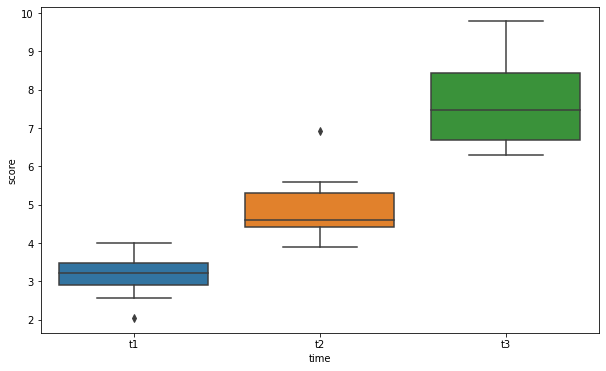

In [4]:
#Create a boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="time", y="score", data=df)
ax

# Assumptions

### Outliers

In [5]:
def outliers(dep, ind):
    dicts = {'Outliers':{}}
    for ind_cat in pd.unique(df[ind]):
        Q1, Q3 = np.percentile(df[dep][df[ind] == ind_cat], [25,75])
        IQR = Q3-Q1
        lower_fence, upper_fence= Q1-(1.5*IQR), Q3+(1.5*IQR)
        new_dataset = []
        for i in df[dep][df[ind] == ind_cat]:
            if i < lower_fence or i > upper_fence:
                new_dataset.append(i)
        dicts['Outliers'][f'{ind_cat}'] = new_dataset
    return pd.DataFrame(dicts)

In [6]:
outliers('score', 'time')

,Outliers
t1,[2.04586801267893]
t2,[6.91291524645931]
t3,[]


### Normality

In [7]:
def shapiro(dep, ind):
    normality = {'Shapiro':{}}
    import scipy.stats as stats
    for ind_cat in pd.unique(df[ind]):
        result = stats.shapiro(df[dep][df[ind] == ind_cat])
        normality['Shapiro'][f'{ind_cat}'] = result
    return pd.DataFrame(normality)

In [8]:
shapiro('score', 'time')

,Shapiro
t1,"(0.9666900634765625, 0.8585755825042725)"
t2,"(0.875884473323822, 0.11699521541595459)"
t3,"(0.9227149486541748, 0.38015690445899963)"


C:\ProgramData\Anaconda3\envs\All\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


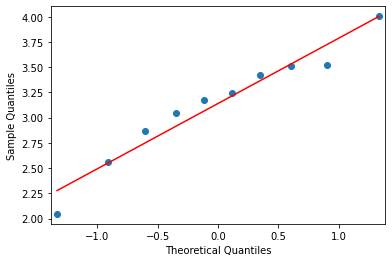

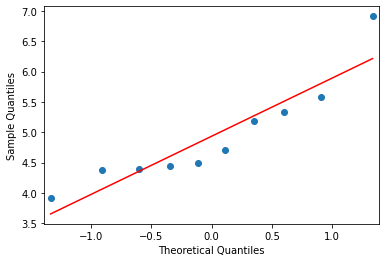

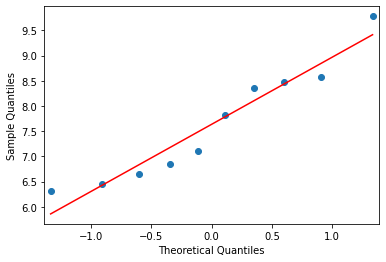

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.qqplot(df.query('time == "t1"')['score'], line='r')
sm.qqplot(df.query('time == "t2"')['score'], line='r')
sm.qqplot(df.query('time == "t3"')['score'], line='r')
plt.show()

### Sphericity

In [10]:
import pingouin as pg
pg.sphericity(df, dv='score', subject='id',
           within='time')

SpherResults(spher=True, W=0.550853404669156, chi2=4.770292467677473, dof=2, pval=0.09207551403887482)

## Statsmodels One-Way_Repeated Measure ANOVA

In [11]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(df, 'score', 'id', within=['time'])
res = aovrm.fit()
res.summary()

,F Value,Num DF,Den DF,Pr > F
time,55.4690,2.0000,18.0000,0.0000


## Pingouin One-Way_Repeated Measure ANOVA

In [12]:
import pingouin as pg
aov = pg.rm_anova(dv='score', within='time', subject='id', data=df, detailed=True)
aov.round(2)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,time,102.46,2,51.23,55.47,0.0,0.86,0.69
1,Error,16.62,18,0.92,NaN,NaN,NaN,NaN


## Interaction Plot

<AxesSubplot:xlabel='time', ylabel='score'>

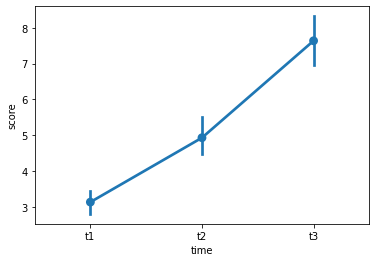

In [13]:
%matplotlib inline
import seaborn as sns
ax = sns.pointplot(x="time", y="score", data=df, order=["t1", "t2", "t3"])
ax

## Pairwise Comparisons

In [14]:
# multiple pairwise paired t-tests between the levels of the within-subjects factor(time)

In [15]:
post_hocs = pg.pairwise_ttests(dv='score', within='time', subject='id', data=df, padjust='bonf')
post_hocs.round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,time,t1,t2,True,True,-4.968,9.0,two-sided,0.001,0.002,bonf,50.694,-2.372
1,time,t1,t3,True,True,-13.228,9.0,two-sided,0.000,0.000,bonf,4.02e+04,-4.800
2,time,t2,t3,True,True,-4.868,9.0,two-sided,0.001,0.003,bonf,45.195,-2.556


## Report

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

t1 vs. t2: Custom statistical test, P_val:2.000e-03
t2 vs. t3: Custom statistical test, P_val:3.000e-03
t1 vs. t3: Custom statistical test, P_val:8.000e-05


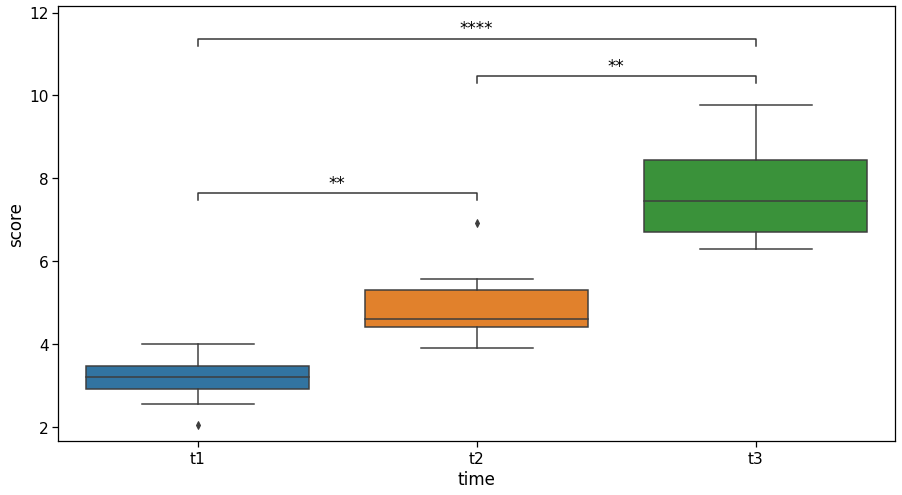

In [16]:
from statannotations.Annotator import Annotator

pvalues = [0.002, 0.00008, 0.003]

# subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plotting_parameters = {
    'data':    df,
    'x':       'time',
    'y':       'score',
#     'palette': palette[1:]
}

pairs = [('t1', 't2'),
         ('t1', 't3'),
         ('t2', 't3')]

with sns.plotting_context('notebook', font_scale = 1.4):
    
    from matplotlib import pyplot as plt
    plt.figure(figsize=(15,8))

    ax=sns.boxplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    plt.show()